In this notebook, I have demonstrated 2 ways for image segmentation.
First one is using transfer learning where I have imported the pre-trained weights of ***maskrcnn_resnet50*** and employed it over an image imported from the Internet. Along with the masked images i have shown the class to which the segmented part of the image belong to.
Second one is where I have defined a CNN model and trained it for ***image segmentation over shapes with random RGB background***. I have genrated the synthetic images using the matplotlib library and displayed the masked images along with the generated one.

In [45]:
# Importing all the libraries required

import os
import random
from PIL import Image, ImageDraw
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms as T
import urllib.request
from google.colab.patches import cv2_imshow

import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Pre-trained maskrcnn_resnet50

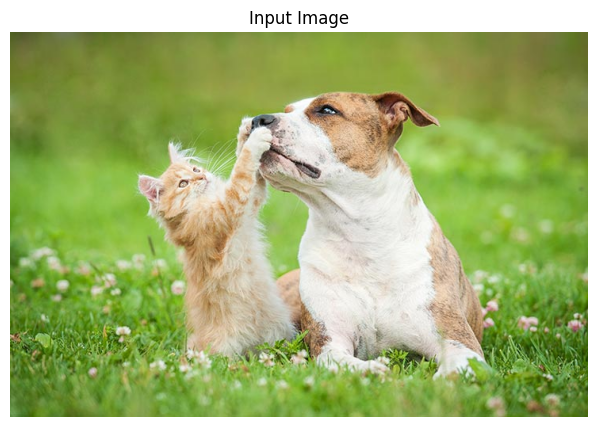

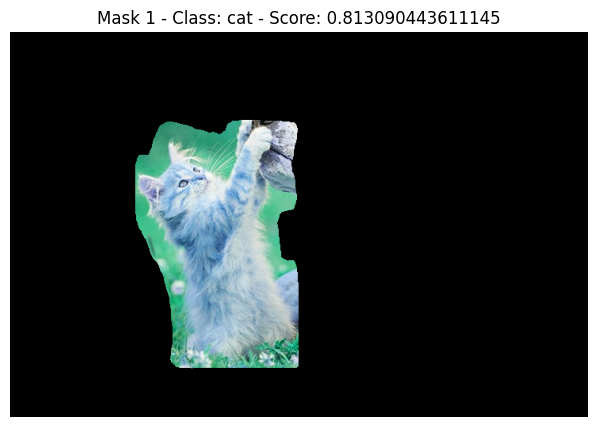

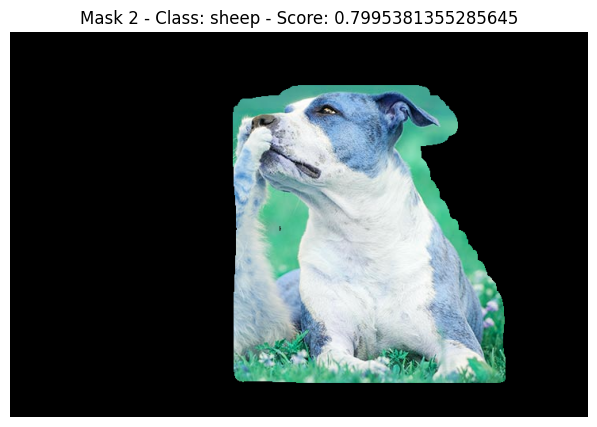

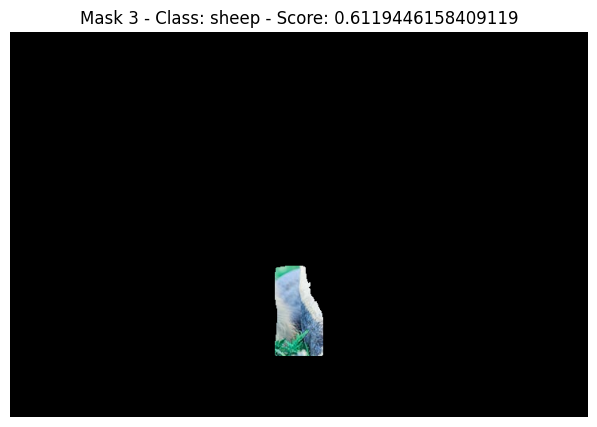

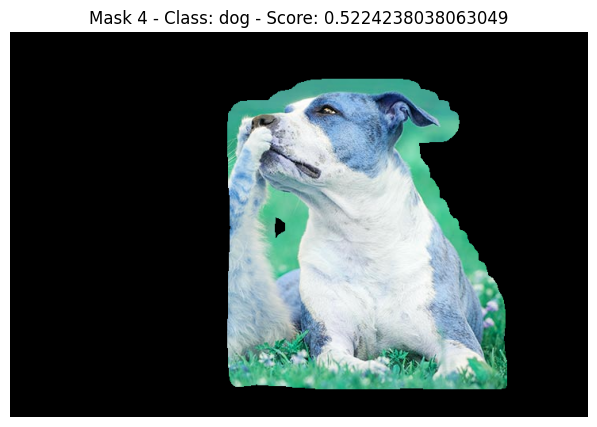

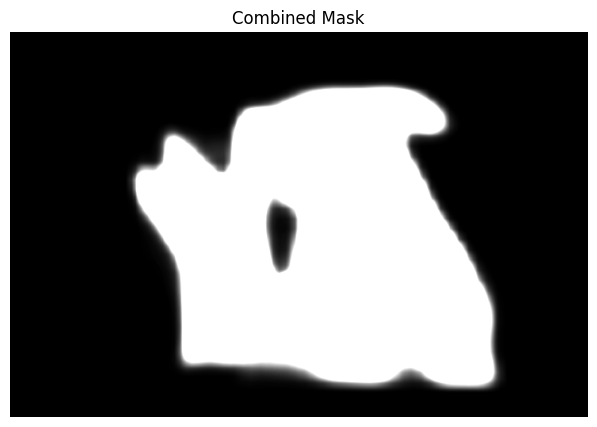

Number of masks: 14


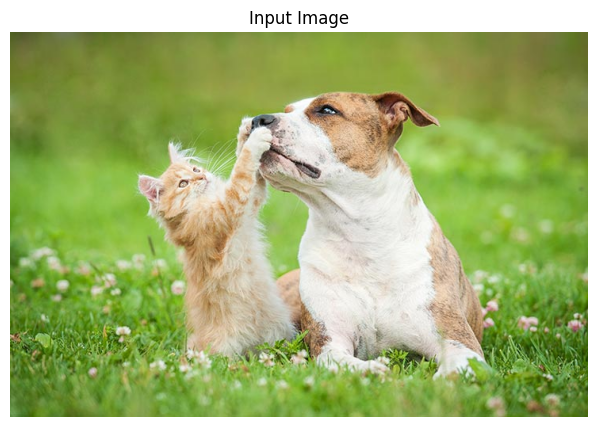

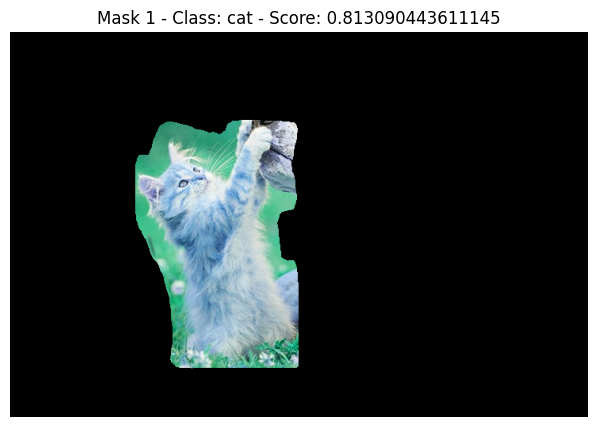

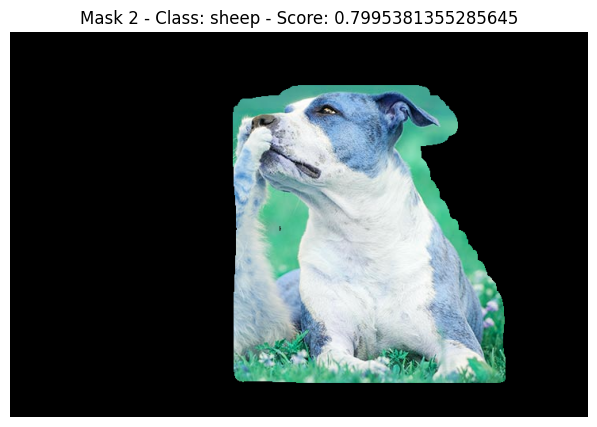

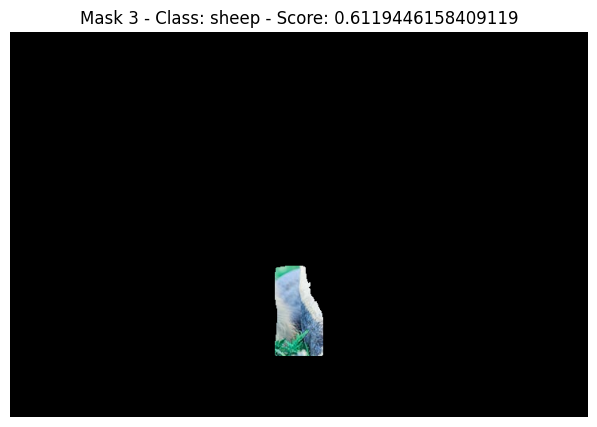

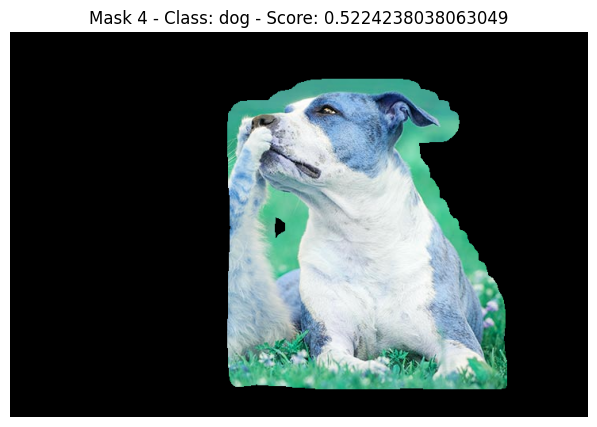

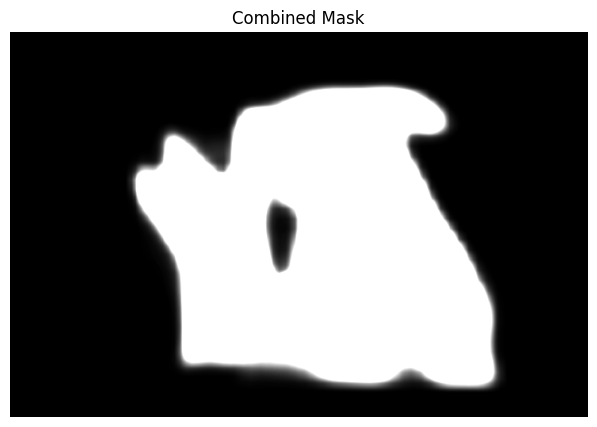

In [46]:
# COCO dataset's class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant',
    'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
    'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli',
    'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

def instance_segmentation(image_path):
    # Pre-trained Mask R-CNN model
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    img = Image.open(image_path)

    # Transformations
    transform = T.Compose([T.ToTensor()])
    img_tensor = transform(img)

    # Inference
    with torch.no_grad():
        pred = model([img_tensor])

    # Retrieving masks, labels, and scores
    if "masks" in pred[0]:
        masks = pred[0]["masks"]
        labels = pred[0]["labels"]
        scores = pred[0]["scores"]

        # The number of masks
        num_masks = masks.shape[0]
        if (num_masks == 0) :
            print("No mask could be generated")
            return 0
        else :
            print("Number of masks:", num_masks)

        # Display the input image
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis("off")
        plt.show()

        # Combining masks for visualization
        combined_mask = np.zeros_like(masks[0, 0])
        for i in range(num_masks):
            mask_img = masks[i, 0].mul(255).byte().cpu().numpy()
            combined_mask += mask_img

            # Applying the mask to the original image
            original_img = cv2.imread(image_path)
            masked_img = cv2.bitwise_and(original_img, original_img, mask=mask_img)

            label_idx = labels[i].item()
            score = scores[i].item()

            # For filtering out the unnecessary classes that would be shown otherwise
            if(score < 0.5):
                continue

            # Map label index to class name
            class_name = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

            # Display the masked image
            plt.figure(figsize=(10, 5))
            plt.imshow(masked_img)
            plt.title(f"Mask {i+1} - Class: {class_name} - Score: {score}")
            plt.axis("off")
            plt.show()

        # Display the combined mask
        combined_mask = np.clip(combined_mask, 0, 255).astype(np.uint8)
        plt.figure(figsize=(10, 5))
        plt.imshow(combined_mask, cmap='gray')
        plt.title("Combined Mask")
        plt.axis("off")
        plt.show()
    else:
        print("No masks detected in the image.")

# Define the image URL
image_url = "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2018/04/24144817/American-Staffordshire-Terrier-lying-outdoors-next-to-a-kitten-that-is-playing-with-the-dogs-nose.jpg"

# Downloading the image from the URL
urllib.request.urlretrieve(image_url, "input_image.jpg")

# Instance segmentation on the downloaded image
instance_segmentation("input_image.jpg")


Below is the code for generating synthetic data and saving them into the output_dir

In [47]:
def generate_synthetic_data(num_samples, output_dir, image_size=(128, 128), min_shapes=1, max_shapes=3):
    os.makedirs(output_dir, exist_ok=True)
    for i in range(num_samples):
        # Generate random background
        background_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        image = Image.new("RGB", image_size, background_color)
        draw = ImageDraw.Draw(image)

        # Generate random shapes
        num_shapes = random.randint(min_shapes, max_shapes)
        for _ in range(num_shapes):
            shape_color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            shape_type = random.choice(['circle', 'rectangle'])
            shape_size = (random.randint(image_size[0] // 8, image_size[0] // 4),
                          random.randint(image_size[1] // 8, image_size[1] // 4))
            position = (random.randint(0, image_size[0] - shape_size[0]),
                        random.randint(0, image_size[1] - shape_size[1]))
            if shape_type == 'circle':
                draw.ellipse([position, (position[0] + shape_size[0], position[1] + shape_size[1])], fill=shape_color)
            elif shape_type == 'rectangle':
                draw.rectangle([position, (position[0] + shape_size[0], position[1] + shape_size[1])], fill=shape_color)

        # Save synthetic image
        image_path = os.path.join(output_dir, f"image_{i}.png")
        image.save(image_path)


Model for the shapes

Epoch 1/20, Loss: 0.5555
Epoch 2/20, Loss: 0.5159
Epoch 3/20, Loss: 0.5145
Epoch 4/20, Loss: 0.5131
Epoch 5/20, Loss: 0.5131
Epoch 6/20, Loss: 0.5121
Epoch 7/20, Loss: 0.5117
Epoch 8/20, Loss: 0.5116
Epoch 9/20, Loss: 0.5113
Epoch 10/20, Loss: 0.5110
Epoch 11/20, Loss: 0.5106
Epoch 12/20, Loss: 0.5107
Epoch 13/20, Loss: 0.5108
Epoch 14/20, Loss: 0.5104
Epoch 15/20, Loss: 0.5103
Epoch 16/20, Loss: 0.5100
Epoch 17/20, Loss: 0.5101
Epoch 18/20, Loss: 0.5099
Epoch 19/20, Loss: 0.5098
Epoch 20/20, Loss: 0.5105


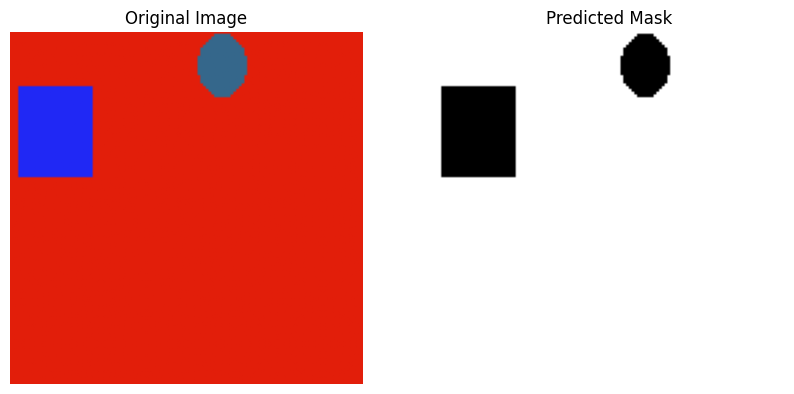

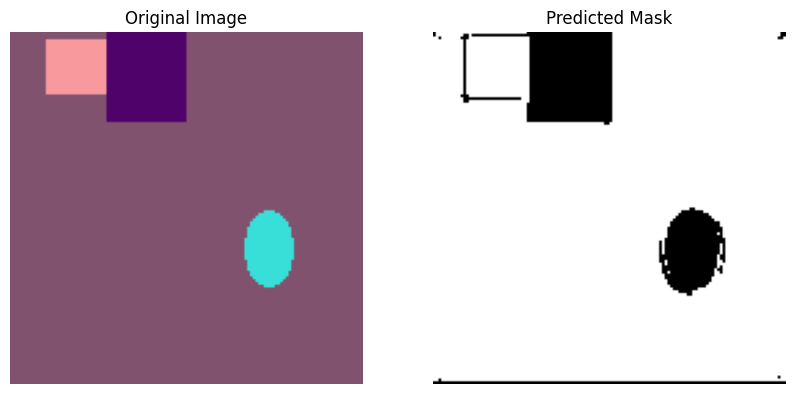

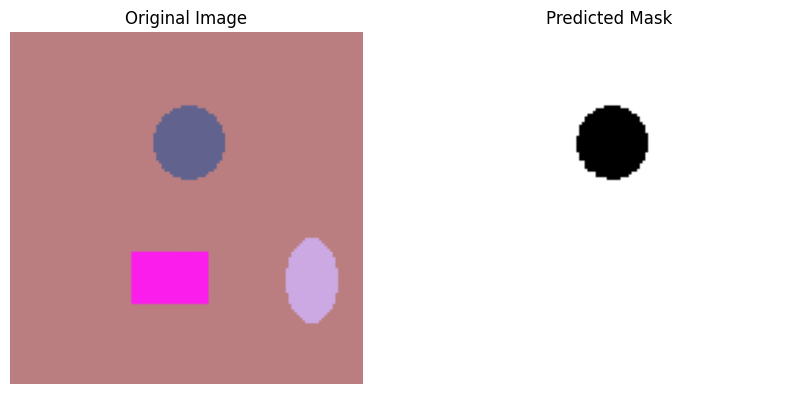

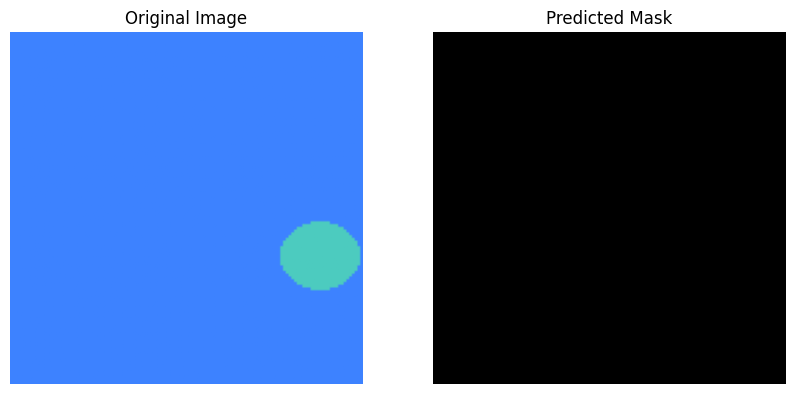

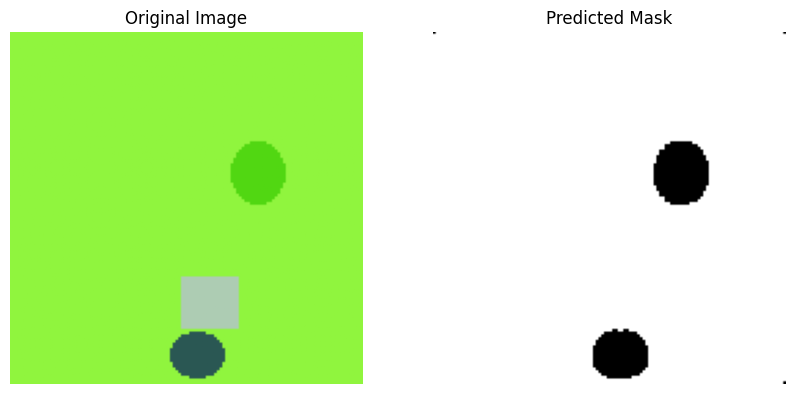

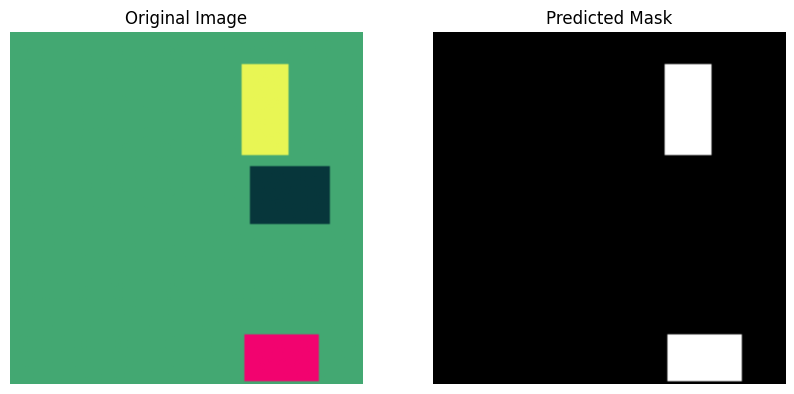

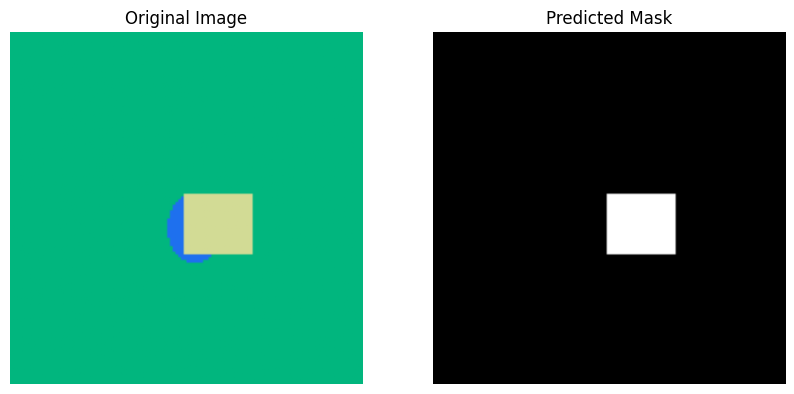

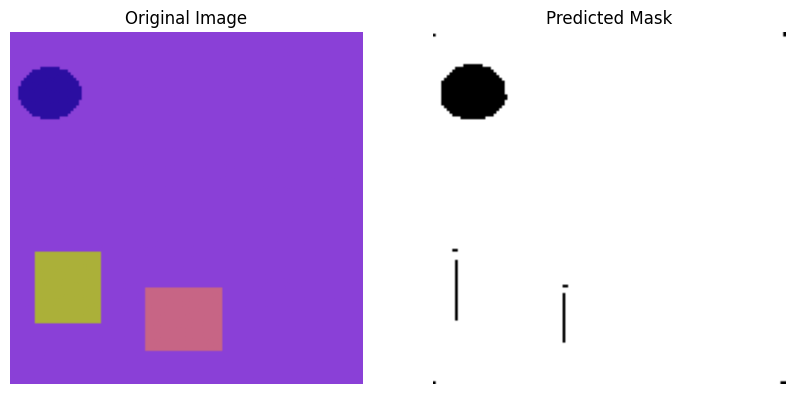

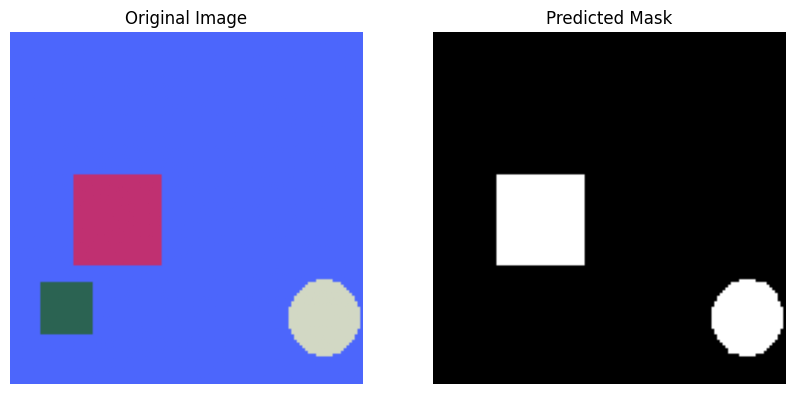

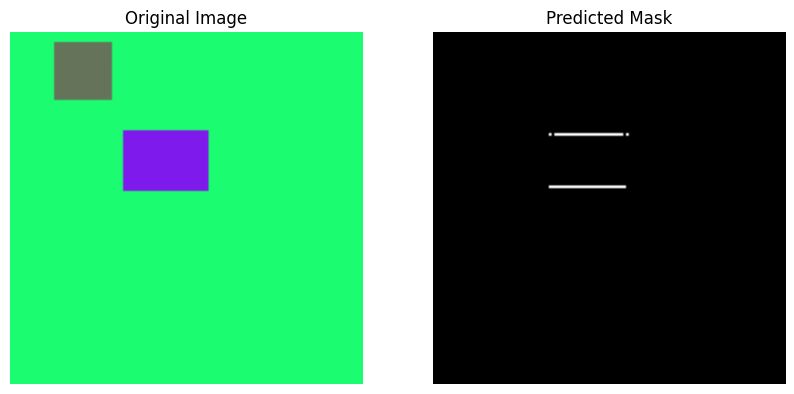

In [48]:
# CNN model for image segmentation
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.sigmoid(self.conv3(x))
        return x

# Synthetic dataset class for loading and pre-processing of images
class Syn_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_list[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Training the segmentation model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images in train_loader:
            images = images.to(device)
            masks_pred = model(images)
            loss = criterion(masks_pred, images[:, :1, :, :])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluating the segmentation model on validation data and displaying masked images
def evaluate_and_display(model, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            masks_pred = model(images)
            masks_pred = masks_pred.cpu().numpy()
            masks_pred = (masks_pred > 0.5).astype(np.uint8)  # Threshold predictions
            for i in range(len(images)):
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
                plt.title('Original Image')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(masks_pred[i, 0], cmap='gray')
                plt.title('Predicted Mask')
                plt.axis('off')
                plt.show()

# Generate synthetic dataset
generate_synthetic_data(num_samples=1000, output_dir="synthetic_dataset")

# Set up paths and hyperparameters
synthetic_data_dir = "synthetic_dataset"
batch_size = 8
num_epochs = 20
lr = 0.001

# Define transformations for the dataset
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

# Datasets and data_loaders
synthetic_dataset = Syn_dataset(root_dir=synthetic_data_dir, transform=transform)
train_size = int(0.990 * len(synthetic_dataset))
val_size = len(synthetic_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(synthetic_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create the model, loss function, and optimizer
model = CNN_model()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the segmentation model
train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs)

# Evaluate the segmentation model on validation data and display masked images
evaluate_and_display(model, val_loader)
